<a href="https://colab.research.google.com/github/EdEnsta/IN104_Edgar_Pereyron_Thea_Levidileon/blob/main/Lime_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Préparation de l'environnement

In [1]:
#packages nécessaires
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
import warnings
from sklearn.linear_model import LinearRegression
np.random.seed(42)

L'entraînement d'un modèle de prédiction pour la reconnaissance d'image étant assez complexe nous utilisons ici les résultats d'un modèle pré-entraîné. Il s'agit du modèle InceptionV3 développé par Google.

------------------------------------------------------------------------

The training of a prediction model for image recognition being quite complex we use here the results of a pre-trained model. It is the InceptionV3 model developed by Google.

In [2]:
#Téléchargement du modèle pré entraîné
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [3]:
#téléchargement d'une image dont on souhaite reconnaître le contenu
from google.colab import files
files.upload()

Saving car_picture2.jpg to car_picture2.jpg


{'car_picture2.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xa0\x01@\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc

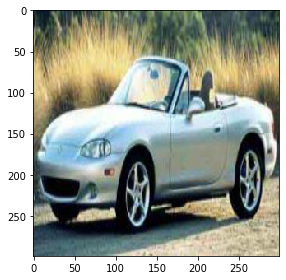

In [4]:
#affichage de l'image et modification des données pour utiliser efficacement InceptionV3
Y = skimage.io.imread("car_picture2.jpg")
Y = skimage.transform.resize(Y, (299,299)) 
skimage.io.imshow(Y)
Y = (Y - 0.5)*2 #traitement plus efficace pour le modèle


# Prédiction des résultats

In [5]:
#reconaissance de l'image par le modèle
predictions = inceptionV3_model.predict(Y[np.newaxis,:,:,:])
best_pred = predictions[0].argsort()[-3:][::-1]

print(decode_predictions(predictions),best_pred,sep='\n')

40960/35363 [==================================] - 0s 0us/step
[[('n03100240', 'convertible', 0.6589685), ('n04285008', 'sports_car', 0.09232462), ('n02704792', 'amphibian', 0.006504421), ('n04264628', 'space_bar', 0.004864896), ('n02974003', 'car_wheel', 0.0022465028)]]
[511 817 408]


Le modèle affiche ses prédictions les plus sûres avec leurs probabilité. Ici le modèle prédit que l'image est une décapotable avec une probabilité de 0.66 ce qui reste correct.

-----------------------------------------------------------------------

The model displays its most reliable predictions with their probability. Here the model predicts that the image is a convertible with a probability of 0.66 which is still correct.

# Explication des résultats

L'idée de la méthode Lime est de séparer l'imgage en plusieurs parties, de perturber les différents morceaux de l'image tout en réalisant des prédictions pour déterminre quelles parties vont être les plus utiles au modèle de reconnaissance. On commence donc par segementer l'image en "superpixels".

------------------------------------------------------------------------

The idea of the Lime method is to separate the image into several parts, to perturb the different parts of the image while making predictions to determine which parts will be the most useful to the recognition model. We start by segmenting the image into "superpixels".

nombre de super pixels =  159


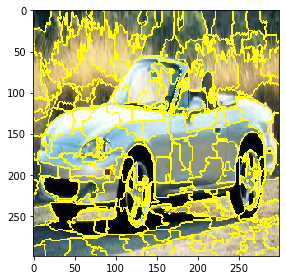

In [6]:
#segmentation de l'image
superpixels = skimage.segmentation.quickshift(Y, kernel_size=3,max_dist=100, ratio=1)
nb_superpixels = np.unique(superpixels).shape[0]
print('nombre de super pixels = ',nb_superpixels)

#affichage de l'image segmentée
skimage.io.imshow(skimage.segmentation.mark_boundaries(Y/2+0.5, superpixels))

On va ensuite créer des perturbations de ces superpixels, en utilisant pour cela une loi aléatoire.

-----------------------------------------------------------------------

We will then create perturbations of these superpixels, using a random law.

In [7]:
#création du tableau de perturbations
nb_perturb = 500
perturbations = np.random.binomial(1, 0.5, size=(nb_perturb, nb_superpixels))

Le tableau de perturbations se compose alors de 0 et de 1 qui vont servir à "allumer" ou "éteindre" les superpixels de l'image.

------------------------------------------------------------------------

The table of disturbances is then composed of 0 and 1 that will serve to "turn on" or "turn off" the superpixels of the image.

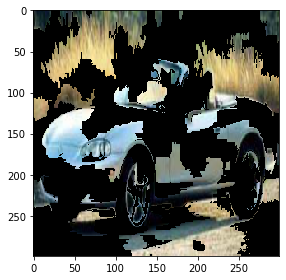

In [8]:
#création de la fonction de perturbation de l'image
def perturbation_image(imgage,perturbation,segments):
  pixels_on = np.where(perturbation == 1)[0]
  hide = np.zeros(segments.shape)

  for i in pixels_on:
    hide[segments == i] = 1
  
  image_perturbée = copy.deepcopy(imgage)
  image_perturbée = image_perturbée*hide[:,:,np.newaxis]

  return image_perturbée

#affichage de l'image perturbée
Y_perturb = perturbation_image(Y/2+0.5,perturbations[0],superpixels)
skimage.io.imshow(Y_perturb)

In [9]:
#perturbation et prédictions successives de l'image
guess = []
for p in perturbations:
  image_perturbée = perturbation_image(Y,p,superpixels)
  prediction = inceptionV3_model.predict(image_perturbée[np.newaxis,:,:,:])
  guess.append(prediction)

guess = np.array(guess)


Ensuite on calcule la distance cosinus entre chaque perturbation générée et l'image d'origine dans le but de leur attribuer un poids.

------------------------------------------------------------------------

Then we calculate the cosine distance between each generated perturbation and the original image in order to assign them a weight.

In [10]:
#calcul des distances
image_originale = np.ones(nb_superpixels)[np.newaxis,:] 
distances = sklearn.metrics.pairwise_distances(perturbations,image_originale, metric='cosine').ravel()

Les distances sont ensuites mise en correspondance avec le poids (compris entre 0 et 1) vie uune fonction noyau. La largeur du noyau est arbitraire et dépend de l'utilisateur.

------------------------------------------------------------------------

The distances are then mapped to the weight (between 0 and 1) thanks to a kernel function. The width of the kernel is arbitrary and depends on the user.

In [11]:
taille_noyau = 0.4
poids = np.sqrt(np.exp(-(distances**2)/taille_noyau**2)) #fonction noyau

On crée alors un modèle plus simple (ici une régression linéaire) à l'aide des données précédentes.

------------------------------------------------------------------------

We then create a simpler model (here a linear regression) using the previous data.

In [12]:
#création et entraînement du modèle plus simple
relevant_class = best_pred[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=guess[:,:,relevant_class], sample_weight=poids)
coeff = simpler_model.coef_[0]

[ 71  78  87 125 111  84]


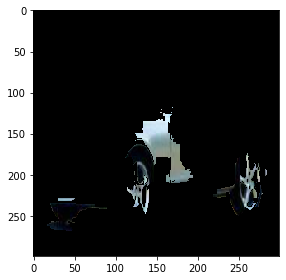

In [14]:
#nombre de superpixels à afficher
nb_best_parts = 6
best_parts = np.argsort(coeff)[-nb_best_parts:] 
print(best_parts)

mask = np.zeros(nb_superpixels) 
mask[best_parts]= True     # on "allume" seulement les parties les plus utiles à la prédiction
skimage.io.imshow(perturbation_image(Y/2+0.5,mask,superpixels) )

On peut alors observer quelles parties de l'images ont été le plus utile à la prédiction.

------------------------------------------------------------------------

We can then observe which parts of the image were the most useful for the prediction.